# Biomedical Model Analysis: Base vs Fine-tuned Comparison

**Objective**: Compare embedding quality and zero-shot performance between base and fine-tuned models (LLaMA3, Mistral, Phi3) against BioMistral baseline.

## Analysis Structure:

**Cell 2 - Setup & Configuration**: Import libraries, define model configurations for all three models, and set analysis parameters (500 samples, BioMistral baseline)

**Cell 3 - Data Loading**: Load test dataset and establish BioMistral baseline accuracy (50.9%) for comparison ranking

**Cell 4 - Core Functions**: Define embedding extraction, quality metrics calculation (KG separation, probe accuracy, clustering), and zero-shot evaluation functions

**Cell 5 - Main Analysis**: Execute comprehensive analysis for each model (base vs fine-tuned), calculate all metrics, perform zero-shot evaluation on 500 samples

**Cell 6 - Embedding Visualization**: Generate t-SNE plots showing embedding space distribution for base vs fine-tuned models across all three architectures

**Cell 7 - Performance Comparison**: Create detailed comparison charts showing improvements, zero-shot ranking, and comprehensive performance analysis

**Cell 8 - Comprehensive Results**: Generate correlation matrices, detailed classification metrics, confusion matrices, and final performance dashboard

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

from unsloth import FastLanguageModel
from peft import PeftModel

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

model_configs = {
    "llama3": {
        "base": "unsloth/llama-3-8b-bnb-4bit",
        "adapters": "./data/fine_tuned_llama3_gda_adapters",
    },
    "mistral": {
        "base": "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
        "adapters": "./data/fine_tuned_mistral7b_gda_adapters",
    },
    "phi3": {
        "base": "unsloth/Phi-3-mini-4k-instruct",
        "adapters": "./data/fine_tuned_phi3_gda_adapters",
    }
}

TEST_FILE = "./data/test.csv"
DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
SAMPLE_SIZE = 500

print("Setup complete")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
🦥 Unsloth Zoo will now patch everything to make training faster!
Setup complete
Setup complete


In [ ]:
biomistral_accuracy = 0.509
sample_df = pd.read_csv(TEST_FILE).sample(n=SAMPLE_SIZE, random_state=42)

print(f"BioMistral baseline accuracy: {biomistral_accuracy:.4f}")
print(f"Loaded {len(sample_df)} test samples")

BioMistral baseline accuracy: 0.5090
Loaded 500 test samples


In [ ]:
def extract_embeddings(model, tokenizer, texts, batch_size=32):
    model.eval()
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to("cuda")

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            batch_emb = outputs.hidden_states[-1].mean(dim=1).float().cpu().numpy()
            embeddings.extend(batch_emb)

    return np.array(embeddings)

def calculate_metrics(embeddings, labels):
    true_idx = np.where(labels == 1)[0]
    false_idx = np.where(labels == 0)[0]

    kg_sep = abs(np.mean(cosine_similarity(embeddings[true_idx])) -
                 np.mean(cosine_similarity(embeddings[false_idx])))

    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3, random_state=42)
    probe = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
    probe_acc = probe.score(X_test, y_test)

    tsne = TSNE(n_components=2, random_state=42).fit_transform(embeddings[:400])
    cluster_quality = silhouette_score(tsne, labels[:400])

    return {"kg_separation": kg_sep, "probe_accuracy": probe_acc,
            "cluster_quality": cluster_quality, "tsne": tsne}

def evaluate_zeroshot(model, tokenizer, texts, labels):
    predictions = []
    for text in tqdm(texts, desc="Zero-shot evaluation"):
        prompt = f"Is this statement true or false? Answer with one word.\n{text}\nAnswer:"
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
        outputs = model.generate(**inputs, max_new_tokens=3, pad_token_id=tokenizer.eos_token_id)
        response = tokenizer.decode(outputs[0][inputs.input_ids.shape[-1]:], skip_special_tokens=True).lower()
        predictions.append(1 if "true" in response else 0)

    return accuracy_score(labels, predictions), predictions

print("Functions loaded")

Functions loaded


In [ ]:
sentences = sample_df["text"].tolist()
labels = sample_df["label"].to_numpy()
results = {}

for model_name, config in model_configs.items():
    print(f"\nAnalyzing {model_name.upper()}")
    print("="*50)

    base_model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=config["base"],
        max_seq_length=1024,
        dtype=DTYPE,
        load_in_4bit=True,
        device_map={"": 0}
    )

    print("Base model analysis...")
    base_embeddings = extract_embeddings(base_model, tokenizer, sentences)
    base_metrics = calculate_metrics(base_embeddings, labels[:len(base_embeddings)])
    base_zeroshot, base_predictions = evaluate_zeroshot(base_model, tokenizer, sentences, labels)

    print("Fine-tuned model analysis...")
    ft_model = PeftModel.from_pretrained(base_model, config["adapters"])
    ft_embeddings = extract_embeddings(ft_model, tokenizer, sentences)
    ft_metrics = calculate_metrics(ft_embeddings, labels[:len(ft_embeddings)])
    ft_zeroshot, ft_predictions = evaluate_zeroshot(ft_model, tokenizer, sentences, labels)

    results[model_name] = {
        "base": {"embeddings": base_embeddings, "metrics": base_metrics, "zeroshot": base_zeroshot, "predictions": base_predictions},
        "finetuned": {"embeddings": ft_embeddings, "metrics": ft_metrics, "zeroshot": ft_zeroshot, "predictions": ft_predictions}
    }

    print(f"Base KG separation: {base_metrics['kg_separation']:.4f}")
    print(f"Fine-tuned KG separation: {ft_metrics['kg_separation']:.4f}")
    print(f"Base probe accuracy: {base_metrics['probe_accuracy']:.4f}")
    print(f"Fine-tuned probe accuracy: {ft_metrics['probe_accuracy']:.4f}")
    print(f"Base zero-shot: {base_zeroshot:.4f}")
    print(f"Fine-tuned zero-shot: {ft_zeroshot:.4f}")

    del base_model, ft_model, tokenizer
    torch.cuda.empty_cache()

print("\nAnalysis complete for all models")


Analyzing LLAMA3


c:\Users\T2510635\anaconda3\envs\research_env\lib\site-packages\unsloth_zoo\gradient_checkpointing.py:341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.6: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4080 SUPER. Num GPUs = 1. Max memory: 15.992 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Base model analysis...
Base model analysis...


Zero-shot evaluation: 100%|██████████| 500/500 [01:09<00:00,  7.18it/s]



Fine-tuned model analysis...


Zero-shot evaluation: 100%|██████████| 500/500 [01:15<00:00,  6.59it/s]



Base KG separation: 0.0491
Fine-tuned KG separation: 0.0731
Base probe accuracy: 0.7067
Fine-tuned probe accuracy: 0.7600
Base zero-shot: 0.5160
Fine-tuned zero-shot: 0.8100

Analyzing MISTRAL
==((====))==  Unsloth 2025.9.6: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4080 SUPER. Num GPUs = 1. Max memory: 15.992 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
==((====))==  Unsloth 2025.9.6: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4080 SUPER. Num GPUs = 1. Max memory: 15.992 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"    

Zero-shot evaluation: 100%|██████████| 500/500 [01:01<00:00,  8.10it/s]



Fine-tuned model analysis...


Zero-shot evaluation: 100%|██████████| 500/500 [01:14<00:00,  6.70it/s]



Base KG separation: 0.1622
Fine-tuned KG separation: 0.1006
Base probe accuracy: 0.6867
Fine-tuned probe accuracy: 0.7800
Base zero-shot: 0.5940
Fine-tuned zero-shot: 0.8380

Analyzing PHI3
==((====))==  Unsloth 2025.9.6: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4080 SUPER. Num GPUs = 1. Max memory: 15.992 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
==((====))==  Unsloth 2025.9.6: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4080 SUPER. Num GPUs = 1. Max memory: 15.992 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Fr

Zero-shot evaluation: 100%|██████████| 500/500 [00:53<00:00,  9.28it/s]



Fine-tuned model analysis...


Zero-shot evaluation: 100%|██████████| 500/500 [01:17<00:00,  6.42it/s]

Base KG separation: 0.0618
Fine-tuned KG separation: 0.1398
Base probe accuracy: 0.6800
Fine-tuned probe accuracy: 0.7200
Base zero-shot: 0.5920
Fine-tuned zero-shot: 0.6880

Analysis complete for all models


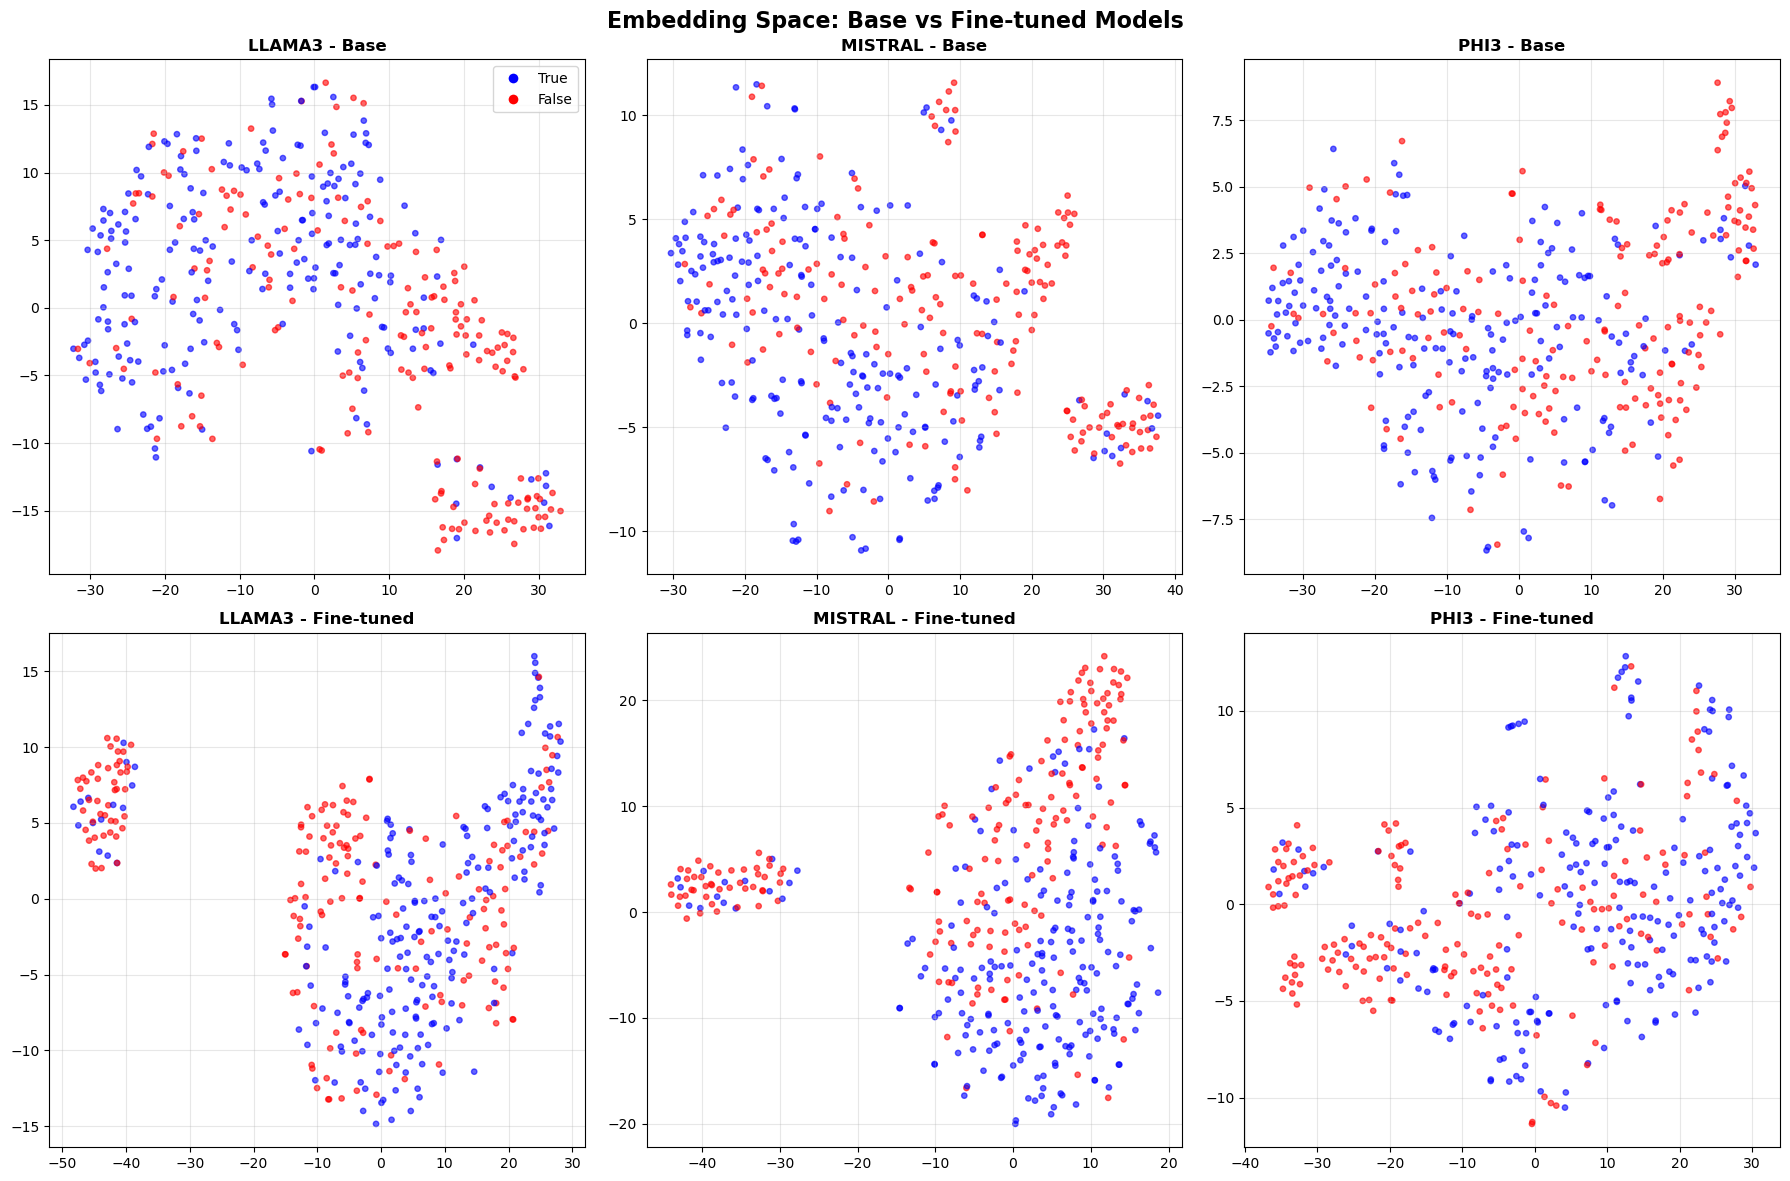

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Embedding Space: Base vs Fine-tuned Models', fontsize=16, fontweight='bold')

model_names = list(results.keys())
colors = ['red' if l == 0 else 'blue' for l in labels[:400]]

for i, model_name in enumerate(model_names):
    ax = axes[0, i]
    base_tsne = results[model_name]["base"]["metrics"]["tsne"]
    ax.scatter(base_tsne[:, 0], base_tsne[:, 1], c=colors, alpha=0.6, s=15)
    ax.set_title(f'{model_name.upper()} - Base', fontweight='bold')
    ax.grid(True, alpha=0.3)

    ax = axes[1, i]
    ft_tsne = results[model_name]["finetuned"]["metrics"]["tsne"]
    ax.scatter(ft_tsne[:, 0], ft_tsne[:, 1], c=colors, alpha=0.6, s=15)
    ax.set_title(f'{model_name.upper()} - Fine-tuned', fontweight='bold')
    ax.grid(True, alpha=0.3)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='True'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='False')
]
axes[0, 0].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

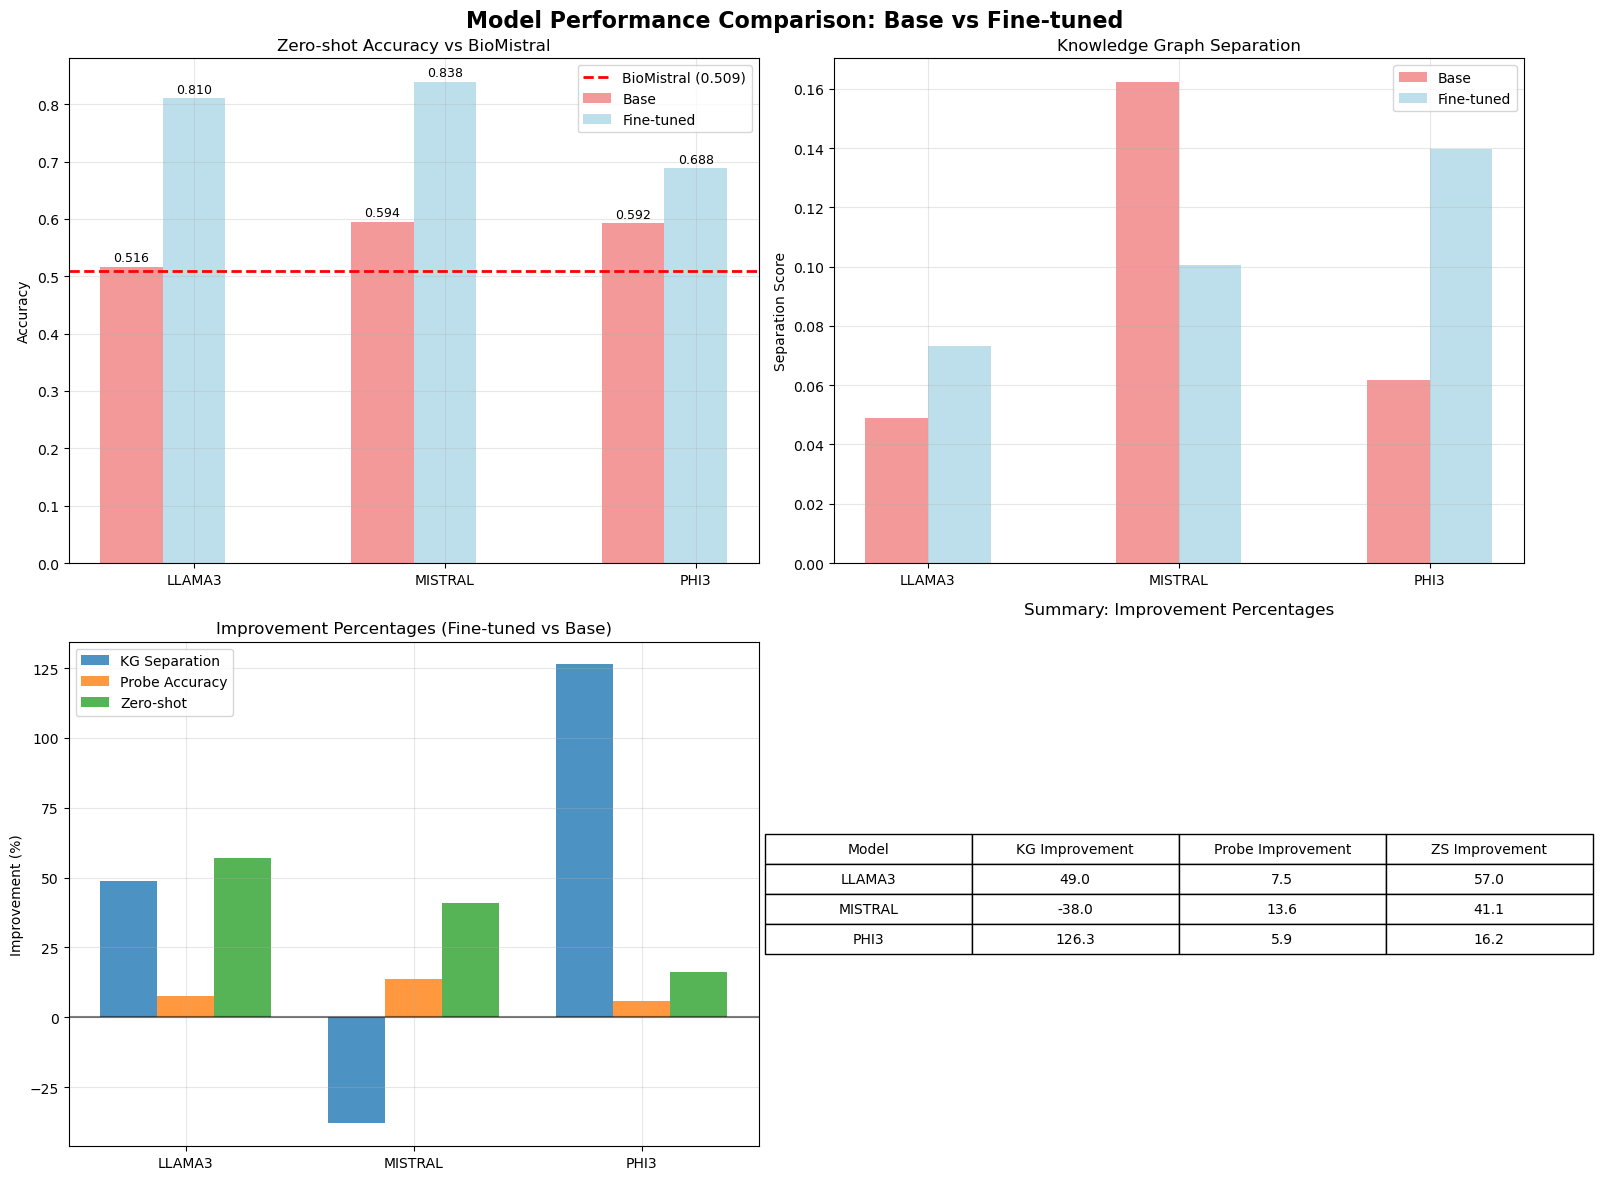

RESULTS SUMMARY
BioMistral baseline accuracy: 0.5090

Fine-tuning improvements:
LLAMA3   | KG: +49.0% | Probe:  +7.5% | ZS: +57.0%
MISTRAL  | KG: -38.0% | Probe: +13.6% | ZS: +41.1%
PHI3     | KG: +126.3% | Probe:  +5.9% | ZS: +16.2%

Zero-shot accuracy ranking:
1. MISTRAL Fine-tuned: 0.8380
2. LLAMA3 Fine-tuned: 0.8100
3. PHI3 Fine-tuned: 0.6880
4. MISTRAL Base: 0.5940
5. PHI3 Base: 0.5920
6. LLAMA3 Base: 0.5160
7. BioMistral: 0.5090

Best zero-shot performance: MISTRAL (0.8380)
Best vs BioMistral: +64.6%


In [ ]:
comparison_data = []
for model_name in model_names:
    base = results[model_name]["base"]
    ft = results[model_name]["finetuned"]

    comparison_data.append({
        "Model": model_name.upper(),
        "Base KG Sep": base["metrics"]["kg_separation"],
        "FT KG Sep": ft["metrics"]["kg_separation"],
        "KG Improvement": ((ft["metrics"]["kg_separation"] - base["metrics"]["kg_separation"]) / base["metrics"]["kg_separation"]) * 100,
        "Base Probe": base["metrics"]["probe_accuracy"],
        "FT Probe": ft["metrics"]["probe_accuracy"],
        "Probe Improvement": ((ft["metrics"]["probe_accuracy"] - base["metrics"]["probe_accuracy"]) / base["metrics"]["probe_accuracy"]) * 100,
        "Base ZS": base["zeroshot"],
        "FT ZS": ft["zeroshot"],
        "ZS Improvement": ((ft["zeroshot"] - base["zeroshot"]) / base["zeroshot"]) * 100
    })

df = pd.DataFrame(comparison_data)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison: Base vs Fine-tuned', fontsize=16, fontweight='bold')

models = df["Model"].tolist()
base_zs = df["Base ZS"].tolist()
ft_zs = df["FT ZS"].tolist()

x = np.arange(len(models))
width = 0.25

bars1 = ax1.bar(x - width, base_zs, width, label='Base', alpha=0.8, color='lightcoral')
bars2 = ax1.bar(x, ft_zs, width, label='Fine-tuned', alpha=0.8, color='lightblue')
ax1.axhline(y=biomistral_accuracy, color='red', linestyle='--', linewidth=2, label=f'BioMistral ({biomistral_accuracy:.3f})')

ax1.set_title('Zero-shot Accuracy vs BioMistral')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

base_kg = df["Base KG Sep"].tolist()
ft_kg = df["FT KG Sep"].tolist()

bars3 = ax2.bar(x - width/2, base_kg, width, label='Base', alpha=0.8, color='lightcoral')
bars4 = ax2.bar(x + width/2, ft_kg, width, label='Fine-tuned', alpha=0.8, color='lightblue')

ax2.set_title('Knowledge Graph Separation')
ax2.set_ylabel('Separation Score')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3)

kg_improvements = df["KG Improvement"].tolist()
probe_improvements = df["Probe Improvement"].tolist()
zs_improvements = df["ZS Improvement"].tolist()

x_metrics = np.arange(len(models))
width = 0.25

ax3.bar(x_metrics - width, kg_improvements, width, label='KG Separation', alpha=0.8)
ax3.bar(x_metrics, probe_improvements, width, label='Probe Accuracy', alpha=0.8)
ax3.bar(x_metrics + width, zs_improvements, width, label='Zero-shot', alpha=0.8)

ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.set_title('Improvement Percentages (Fine-tuned vs Base)')
ax3.set_ylabel('Improvement (%)')
ax3.set_xticks(x_metrics)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.axis('tight')
ax4.axis('off')
table_data = df[["Model", "KG Improvement", "Probe Improvement", "ZS Improvement"]].round(1)
table = ax4.table(cellText=table_data.values, colLabels=table_data.columns,
                  cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax4.set_title('Summary: Improvement Percentages', pad=20)

plt.tight_layout()
plt.show()

print("RESULTS SUMMARY")
print("="*60)
print(f"BioMistral baseline accuracy: {biomistral_accuracy:.4f}")
print("\nFine-tuning improvements:")
for _, row in df.iterrows():
    print(f"{row['Model']: <8} | KG: {row['KG Improvement']:+5.1f}% | Probe: {row['Probe Improvement']:+5.1f}% | ZS: {row['ZS Improvement']:+5.1f}%")

print("\nZero-shot accuracy ranking:")
ranking_data = []
ranking_data.append({"Model": "BioMistral", "Accuracy": biomistral_accuracy})
for _, row in df.iterrows():
    ranking_data.append({"Model": f"{row['Model']} Base", "Accuracy": row['Base ZS']})
    ranking_data.append({"Model": f"{row['Model']} Fine-tuned", "Accuracy": row['FT ZS']})

ranking_df = pd.DataFrame(ranking_data).sort_values('Accuracy', ascending=False).reset_index(drop=True)
for i, row in ranking_df.iterrows():
    print(f"{i+1}. {row['Model']}: {row['Accuracy']:.4f}")

best_zs = df.loc[df['FT ZS'].idxmax()]
print(f"\nBest zero-shot performance: {best_zs['Model']} ({best_zs['FT ZS']:.4f})")
print(f"Best vs BioMistral: {((best_zs['FT ZS'] - biomistral_accuracy) / biomistral_accuracy * 100):+.1f}%")

COMPARATIVE ANALYSIS RESULTS

LLAMA3:
  Knowledge Graph Separation: +49.0%
  Probe Accuracy: +7.5%
  Zero-shot Performance: +57.0%

MISTRAL:
  Knowledge Graph Separation: -38.0%
  Probe Accuracy: +13.6%
  Zero-shot Performance: +41.1%

PHI3:
  Knowledge Graph Separation: +126.3%
  Probe Accuracy: +5.9%
  Zero-shot Performance: +16.2%

AVERAGE IMPROVEMENTS:
  Knowledge Graph Quality: +45.8%
  Probe Accuracy: +9.0%
  Zero-shot Performance: +38.1%

Best performing model: MISTRAL
Zero-shot accuracy: 0.838
Improvement vs BioMistral baseline: +64.6%

Zero-shot accuracy ranking:
1. MISTRAL Fine-tuned: 0.8380
2. LLAMA3 Fine-tuned: 0.8100
3. PHI3 Fine-tuned: 0.6880
4. MISTRAL Base: 0.5940
5. PHI3 Base: 0.5920
6. LLAMA3 Base: 0.5160
7. BioMistral: 0.5090

CORRELATION MATRICES


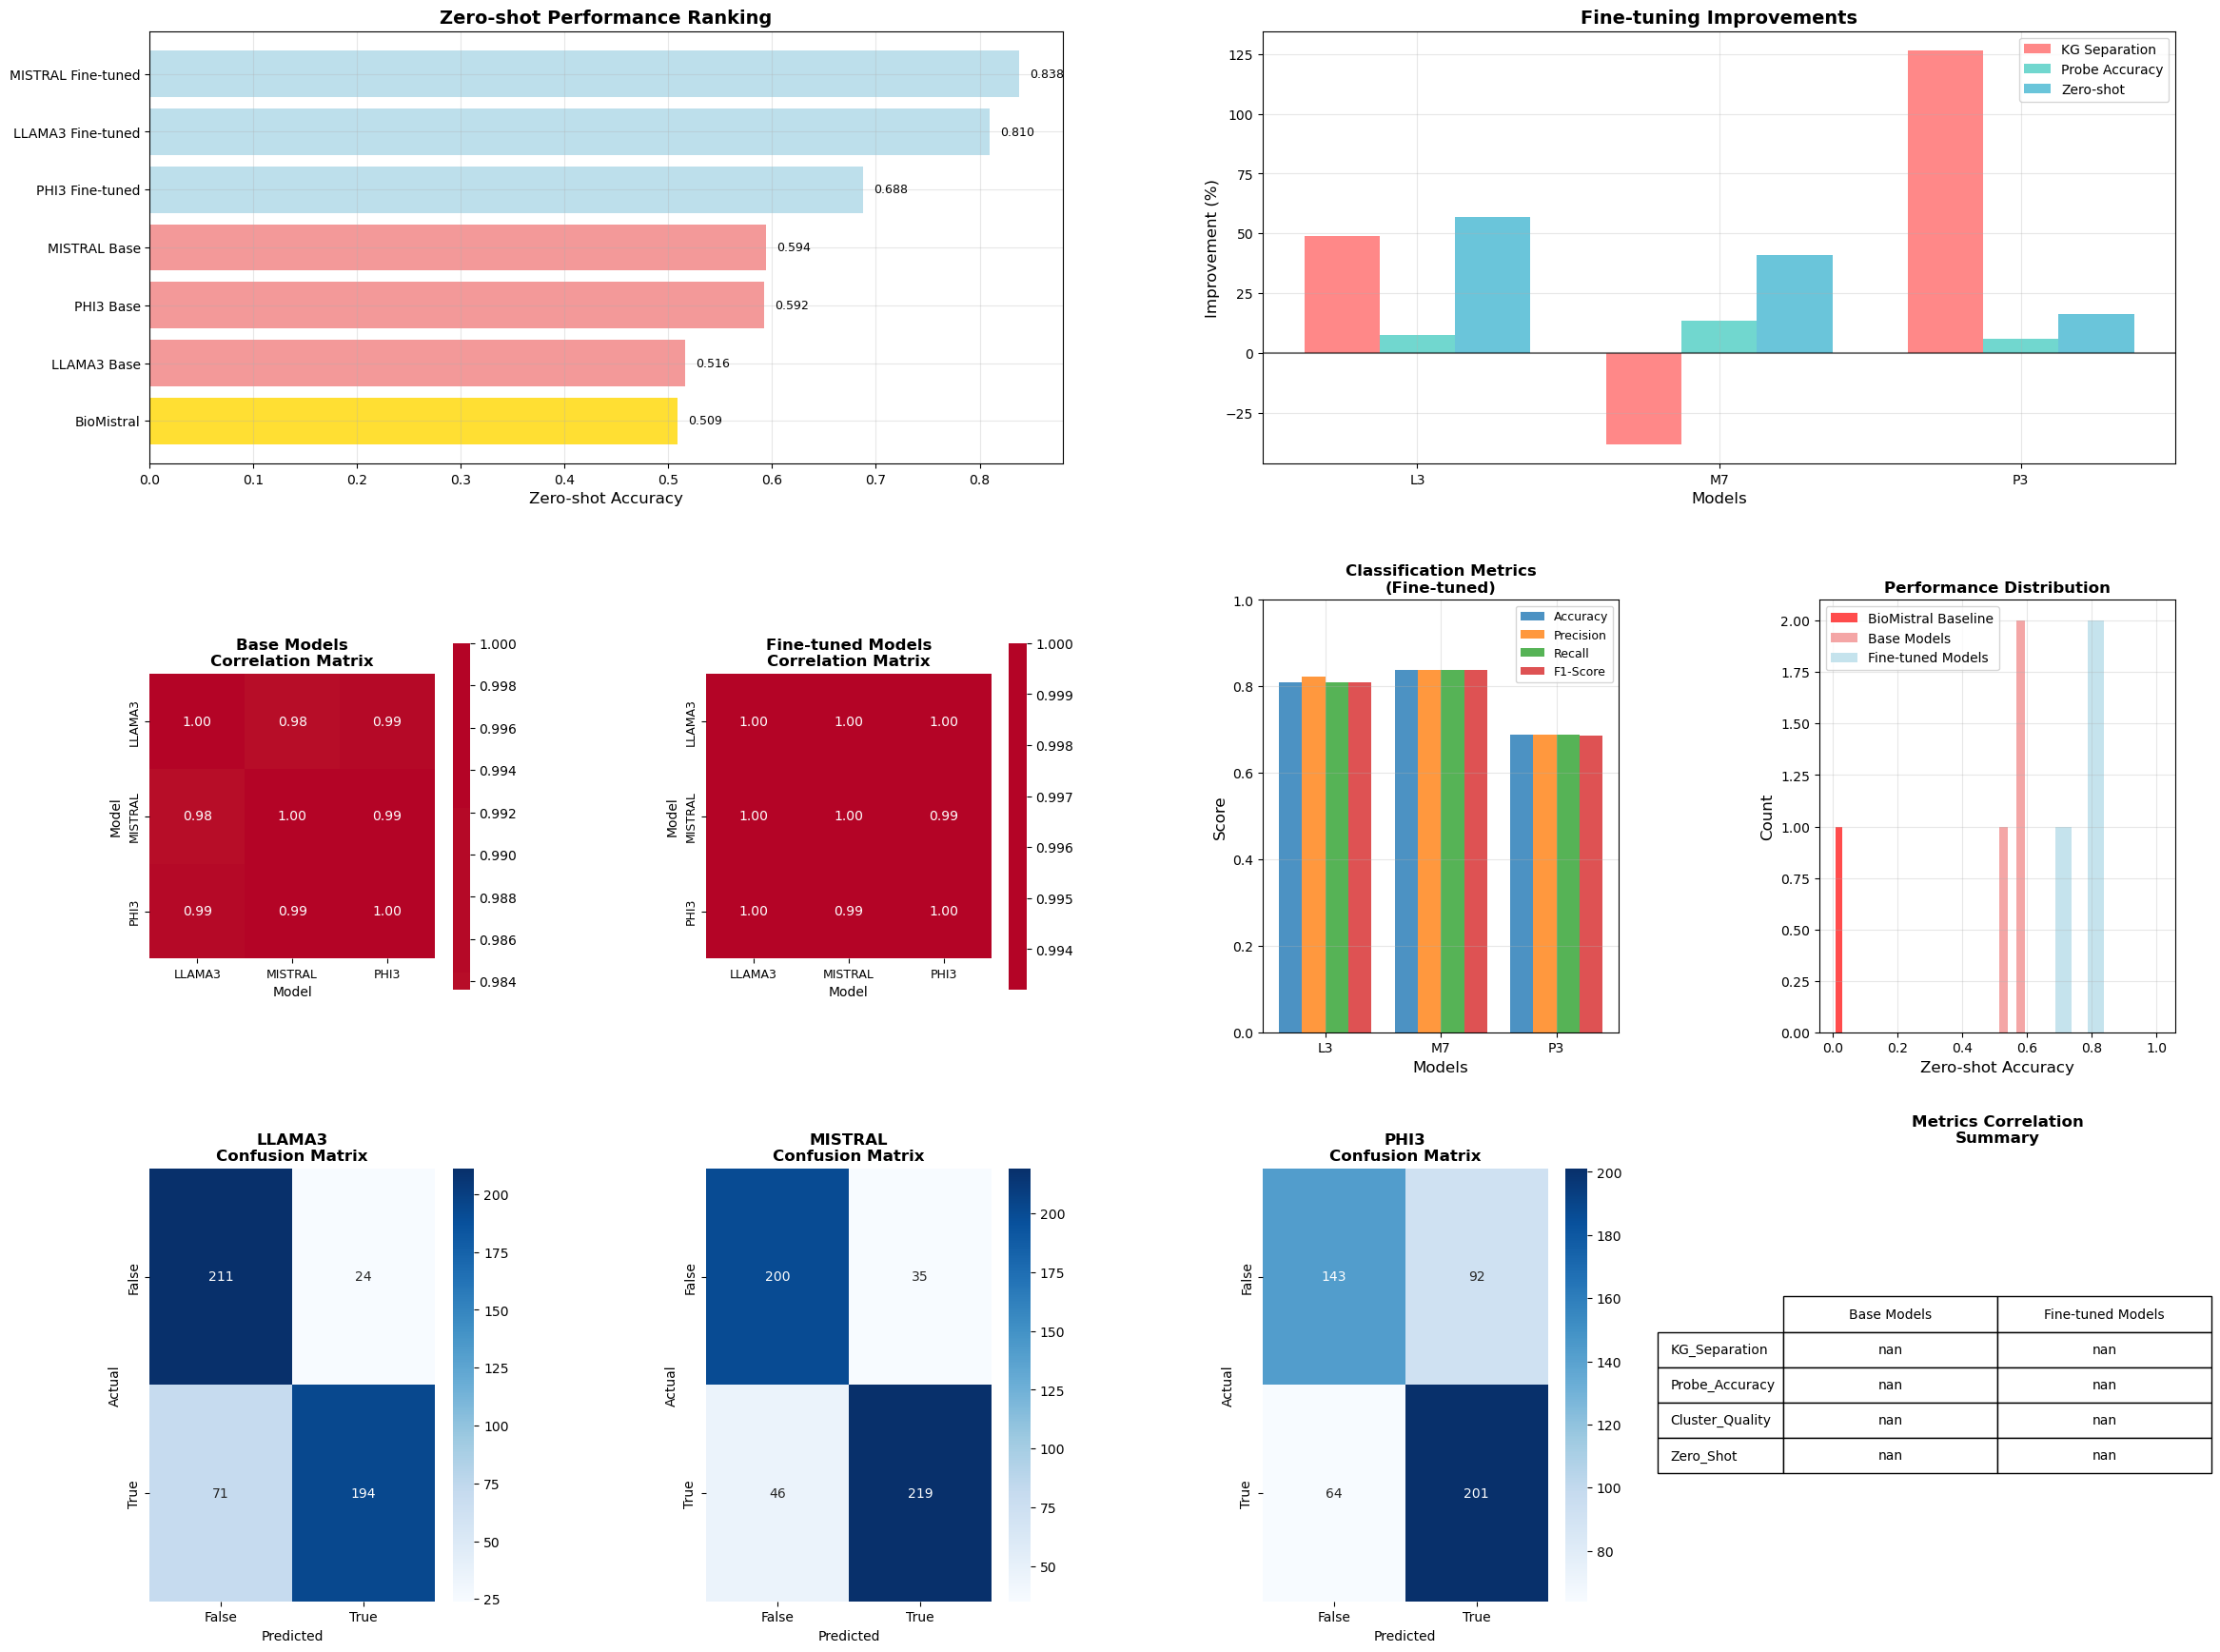


DETAILED CLASSIFICATION METRICS

LLAMA3 FINE-TUNED MODEL:
----------------------------------------
                   precision    recall  f1-score   support

False Association       0.75      0.90      0.82       235
 True Association       0.89      0.73      0.80       265

         accuracy                           0.81       500
        macro avg       0.82      0.81      0.81       500
     weighted avg       0.82      0.81      0.81       500


MISTRAL FINE-TUNED MODEL:
----------------------------------------
                   precision    recall  f1-score   support

False Association       0.81      0.85      0.83       235
 True Association       0.86      0.83      0.84       265

         accuracy                           0.84       500
        macro avg       0.84      0.84      0.84       500
     weighted avg       0.84      0.84      0.84       500


PHI3 FINE-TUNED MODEL:
----------------------------------------
                   precision    recall  f1-score   su

In [ ]:
if 'df' in locals():
    from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
    import seaborn as sns

    print("COMPARATIVE ANALYSIS RESULTS")
    print("="*60)

    for _, row in df.iterrows():
        model = row['Model']
        kg_imp = row['KG Improvement']
        probe_imp = row['Probe Improvement']
        zs_imp = row['ZS Improvement']

        print(f"\n{model}:")
        print(f"  Knowledge Graph Separation: {kg_imp:+.1f}%")
        print(f"  Probe Accuracy: {probe_imp:+.1f}%")
        print(f"  Zero-shot Performance: {zs_imp:+.1f}%")

    avg_kg = df['KG Improvement'].mean()
    avg_probe = df['Probe Improvement'].mean()
    avg_zs = df['ZS Improvement'].mean()

    print(f"\nAVERAGE IMPROVEMENTS:")
    print(f"  Knowledge Graph Quality: {avg_kg:+.1f}%")
    print(f"  Probe Accuracy: {avg_probe:+.1f}%")
    print(f"  Zero-shot Performance: {avg_zs:+.1f}%")

    best_model = df.loc[df['FT ZS'].idxmax()]
    print(f"\nBest performing model: {best_model['Model']}")
    print(f"Zero-shot accuracy: {best_model['FT ZS']:.3f}")
    improvement_vs_baseline = ((best_model['FT ZS'] - biomistral_accuracy) / biomistral_accuracy * 100)
    print(f"Improvement vs BioMistral baseline: {improvement_vs_baseline:+.1f}%")

    print("\nZero-shot accuracy ranking:")
    ranking_data = []
    ranking_data.append({"Model": "BioMistral", "Accuracy": biomistral_accuracy})
    for _, row in df.iterrows():
        ranking_data.append({"Model": f"{row['Model']} Base", "Accuracy": row['Base ZS']})
        ranking_data.append({"Model": f"{row['Model']} Fine-tuned", "Accuracy": row['FT ZS']})

    ranking_df = pd.DataFrame(ranking_data).sort_values('Accuracy', ascending=False).reset_index(drop=True)
    for i, row in ranking_df.iterrows():
        print(f"{i+1}. {row['Model']}: {row['Accuracy']:.4f}")

    # Create correlation matrices for base and fine-tuned models
    print("\n" + "="*60)
    print("CORRELATION MATRICES")
    print("="*60)

    base_corr_data = []
    ft_corr_data = []

    for model_name in model_names:
        base_data = results[model_name]["base"]
        ft_data = results[model_name]["finetuned"]

        base_corr_data.append({
            'Model': model_name.upper(),
            'KG_Separation': base_data["metrics"]["kg_separation"],
            'Probe_Accuracy': base_data["metrics"]["probe_accuracy"],
            'Cluster_Quality': base_data["metrics"]["cluster_quality"],
            'Zero_Shot': base_data["zeroshot"]
        })

        ft_corr_data.append({
            'Model': model_name.upper(),
            'KG_Separation': ft_data["metrics"]["kg_separation"],
            'Probe_Accuracy': ft_data["metrics"]["probe_accuracy"],
            'Cluster_Quality': ft_data["metrics"]["cluster_quality"],
            'Zero_Shot': ft_data["zeroshot"]
        })

    base_corr_df = pd.DataFrame(base_corr_data).set_index('Model')
    ft_corr_df = pd.DataFrame(ft_corr_data).set_index('Model')

    # Create comprehensive visualization dashboard
    fig = plt.figure(figsize=(24, 18))

    # 1. Performance ranking (larger, cleaner)
    ax1 = plt.subplot(3, 4, (1, 2))
    colors_rank = ['gold' if 'BioMistral' in model else 'lightblue' if 'Fine-tuned' in model else 'lightcoral'
                   for model in ranking_df['Model']]
    bars = ax1.barh(range(len(ranking_df)), ranking_df['Accuracy'], color=colors_rank, alpha=0.8)
    ax1.set_yticks(range(len(ranking_df)))
    ax1.set_yticklabels(ranking_df['Model'], fontsize=10)
    ax1.set_xlabel('Zero-shot Accuracy', fontsize=12)
    ax1.set_title('Zero-shot Performance Ranking', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()

    for i, (bar, acc) in enumerate(zip(bars, ranking_df['Accuracy'])):
        ax1.text(acc + 0.01, bar.get_y() + bar.get_height()/2, f'{acc:.3f}',
                ha='left', va='center', fontsize=9)

    # 2. Model improvement comparison
    ax2 = plt.subplot(3, 4, (3, 4))
    models_short = [m.replace('LLAMA3', 'L3').replace('MISTRAL', 'M7').replace('PHI3', 'P3') for m in df['Model']]
    x_pos = np.arange(len(models_short))
    width = 0.25

    ax2.bar(x_pos - width, df['KG Improvement'], width, label='KG Separation', alpha=0.8, color='#FF6B6B')
    ax2.bar(x_pos, df['Probe Improvement'], width, label='Probe Accuracy', alpha=0.8, color='#4ECDC4')
    ax2.bar(x_pos + width, df['ZS Improvement'], width, label='Zero-shot', alpha=0.8, color='#45B7D1')

    ax2.set_xlabel('Models', fontsize=12)
    ax2.set_ylabel('Improvement (%)', fontsize=12)
    ax2.set_title('Fine-tuning Improvements', fontweight='bold', fontsize=14)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(models_short)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # 3. Correlation matrix for base models
    ax3 = plt.subplot(3, 4, 5)
    base_corr = base_corr_df.T.corr()
    sns.heatmap(base_corr, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', ax=ax3, cbar_kws={'shrink': 0.8})
    ax3.set_title('Base Models\nCorrelation Matrix', fontweight='bold', fontsize=12)
    ax3.tick_params(axis='both', labelsize=9)

    # 4. Correlation matrix for fine-tuned models
    ax4 = plt.subplot(3, 4, 6)
    ft_corr = ft_corr_df.T.corr()
    sns.heatmap(ft_corr, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', ax=ax4, cbar_kws={'shrink': 0.8})
    ax4.set_title('Fine-tuned Models\nCorrelation Matrix', fontweight='bold', fontsize=12)
    ax4.tick_params(axis='both', labelsize=9)

    # 5. Classification metrics for fine-tuned models
    ax5 = plt.subplot(3, 4, 7)
    ft_metrics_data = []
    for model_name in model_names:
        if model_name in results and 'predictions' in results[model_name]['finetuned']:
            y_true = labels
            y_pred = results[model_name]['finetuned']['predictions']
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
            accuracy = accuracy_score(y_true, y_pred)

            ft_metrics_data.append({
                'Model': model_name.upper(),
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })

    if ft_metrics_data:
        metrics_df = pd.DataFrame(ft_metrics_data)
        x_pos = np.arange(len(metrics_df))
        width = 0.2

        ax5.bar(x_pos - 1.5*width, metrics_df['Accuracy'], width, label='Accuracy', alpha=0.8)
        ax5.bar(x_pos - 0.5*width, metrics_df['Precision'], width, label='Precision', alpha=0.8)
        ax5.bar(x_pos + 0.5*width, metrics_df['Recall'], width, label='Recall', alpha=0.8)
        ax5.bar(x_pos + 1.5*width, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)

        ax5.set_xlabel('Models', fontsize=12)
        ax5.set_ylabel('Score', fontsize=12)
        ax5.set_title('Classification Metrics\n(Fine-tuned)', fontweight='bold', fontsize=12)
        ax5.set_xticks(x_pos)
        ax5.set_xticklabels([m.replace('LLAMA3', 'L3').replace('MISTRAL', 'M7').replace('PHI3', 'P3') for m in metrics_df['Model']])
        ax5.legend(fontsize=9)
        ax5.grid(True, alpha=0.3)
        ax5.set_ylim(0, 1)

    # 6. Performance distribution (fixed)
    ax6 = plt.subplot(3, 4, 8)

    baseline_scores = [biomistral_accuracy]
    base_scores = df['Base ZS'].tolist()
    ft_scores = df['FT ZS'].tolist()

    ax6.hist([baseline_scores], bins=1, alpha=0.7, label='BioMistral Baseline',
             color='red', width=0.02, density=False)
    ax6.hist([base_scores], bins=3, alpha=0.7, label='Base Models',
             color='lightcoral', density=False)
    ax6.hist([ft_scores], bins=3, alpha=0.7, label='Fine-tuned Models',
             color='lightblue', density=False)

    ax6.set_xlabel('Zero-shot Accuracy', fontsize=12)
    ax6.set_ylabel('Count', fontsize=12)
    ax6.set_title('Performance Distribution', fontweight='bold', fontsize=12)
    ax6.legend(fontsize=10)
    ax6.grid(True, alpha=0.3)

    # 7-9. Confusion matrices for fine-tuned models (bottom row)
    for idx, model_name in enumerate(model_names):
        if model_name in results and 'predictions' in results[model_name]['finetuned']:
            ax = plt.subplot(3, 4, 9 + idx)
            y_true = labels
            y_pred = results[model_name]['finetuned']['predictions']
            cm = confusion_matrix(y_true, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=['False', 'True'], yticklabels=['False', 'True'])
            ax.set_title(f'{model_name.upper()}\nConfusion Matrix', fontweight='bold', fontsize=12)
            ax.set_xlabel('Predicted', fontsize=10)
            ax.set_ylabel('Actual', fontsize=10)

    # 10. Metrics correlation table
    ax10 = plt.subplot(3, 4, 12)
    ax10.axis('off')

    # Create combined correlation table
    corr_comparison = pd.DataFrame({
        'Base Models': base_corr_df.corrwith(base_corr_df.iloc[0]).round(3),
        'Fine-tuned Models': ft_corr_df.corrwith(ft_corr_df.iloc[0]).round(3)
    })

    table = ax10.table(cellText=corr_comparison.values,
                      rowLabels=corr_comparison.index,
                      colLabels=corr_comparison.columns,
                      cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    ax10.set_title('Metrics Correlation\nSummary', fontweight='bold', fontsize=12, pad=20)

    plt.tight_layout(pad=3.0)
    plt.show()

    print("\n" + "="*80)
    print("DETAILED CLASSIFICATION METRICS")
    print("="*80)

    for model_name in model_names:
        if model_name in results and 'predictions' in results[model_name]['finetuned']:
            print(f"\n{model_name.upper()} FINE-TUNED MODEL:")
            print("-" * 40)
            y_true = labels
            y_pred = results[model_name]['finetuned']['predictions']
            print(classification_report(y_true, y_pred, target_names=['False Association', 'True Association']))

    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)
    print("\nBase Models Correlation Matrix:")
    print(base_corr.round(3))
    print("\nFine-tuned Models Correlation Matrix:")
    print(ft_corr.round(3))

else:
    print("Run previous cells to generate analysis results")